# ABOUT THIS NOTEBOOK
## Purpose
This notebook attempts to fit various machine learning models on the data set.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: plots, parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Implement functions for common tasks
    * Scoring
    * Learning curves
    * Validation curves
    * Hyperparameter selection
* Run the following algorithms:
    * Random Forest Regressor
    * K Nearest Neighbors
    * Support Vector Machines
    * Linear Regression
    * Gradient Boosting Regressor
* For each of the algorithms perform the following:
    * Estimate feature importance / ranking
    * Learning curve, Validation curve plots
    * Hyperparameter selection

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import re
import timeit

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn & six'

Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [4]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 55) (66528, 55) 




## Generate scaled features for train & test sets

In [5]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

# IMPLEMENT FUNCTIONS FOR COMMON TASKS

## Scoring

In [6]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for gap is in namesake column
def gap_estimate(**kwargs):
    """
    Generate scores for gap.
    
    Parameters
    ----------
    gX_train  : array containing train features
    gX_test   : array containing test features
    g_fitfunc : function to use for predicting
    """
    
    gX_train     = kwargs["gX_train"]
    gX_test      = kwargs["gX_test"]
    g_fitfunc    = kwargs["g_fitfunc"]
    
    print "\n\nGAP FORECASTING"
    print     "==============="

    # Generate predictions for train & test sets
    gy_pred_train    = target_scaler.inverse_transform(g_fitfunc.predict(gX_train))
    gy_pred_test     = target_scaler.inverse_transform(g_fitfunc.predict(gX_test))

    # Extract expected train & test values
    gy_train    = X_train['gap']
    gy_test     = X_test['gap']

    # Evaluate scores and print results
    print_score(gy_train, gy_pred_train, gy_test, gy_pred_test) 
    return

def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*7)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}' .format(s, m, r, mp)


def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

In [7]:
# Create a scorer function using the MAPE metric
# Use the training data size (144 time slots * 14 days) for q value

mape_scorer = make_scorer(mape_score, greater_is_better=False, q=((144*14)-1))

## Generate Learning & Validation Curves

In [8]:
def generate_learningcurves(sparse=False,**kwargs):
    ''' Generate learning curves by varying training sizes.
    Use Training vs Cross-validation curves.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    
    Returns:
    Generates the learning curves plot.
    '''
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
    alg           = kwargs["alg"]
    alg_name      = kwargs["alg_name"]
    
    if (sparse):
        train_sizes = np.linspace(.01, 1.0, 6)
    else:
        train_sizes = np.linspace(.01, 1.0, 20)
    
    # Plot learning curve
    X, y = gX_train, gy_train
    title = 'Learning Curves for Gap (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)
    estimator = alg
    plot_learning_curve(estimator, alg_name, title, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    plt.show()
    

        
def plot_learning_curve(estimator, alg_name, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curves.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    alg_name : name of the algorithm being tested
    
    title : string
            Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
           Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
         If an integer is passed, it is the number of folds (defaults to 3).
         Specific cross-validation objects can be passed, see
         sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
             
    train_sizes : array, optional
                  Sizes of train set to use for generating the learning curve plot 
    """
    # Plot Learning Curve
    plt.figure(figsize=(15,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    

    start = timeit.default_timer()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Learning Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s) 
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    
    # Print Scores
    for train_size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
        print ('Train Size: {0:7d} Train Score: {1:.3f} Test Score: {2:.3f}' .format(int(train_size), float(train_score), float(test_score)))
    
    return plt


def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))


def plot_validation_curve(estimator, X, y, param_name, param_range, 
                          scoring, plot_title, x_label, y_label, n_jobs=-1):
    """
    Generate a simple plot of the validation curve for one hyperparameter.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : string with the name of the hyperparameter
    
    param_range : array with values for the hyperparameter
    
    scoring : scoring function to use
    
    plot_title : string
            Title for the chart.
            
    x_label: label for x-axis of the plot
    
    y_label: lable for y-axis of the plot
    
    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
    """
    
    # Cross validation with 10 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=n_jobs)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:7d}    Train Score: {2:.3f} Test Score: {3:.3f}' .format(param_name, int(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

## Select Hyperparameters

In [9]:
def select_hyperparams(**kwargs):
    ''' Perform hyperparameter selection using grid search with 5x2 cross validation.
    Generate learning curves, scores for the best estimator.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    gX_test -- Input features for test
    gy_test -- Target values for test
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    param_grid -- Dictionary with hyperparameters and their range
    scoring_func -- Scoring function for the algorithm
    
    Returns:
    Best estimator found by performing grid search.
    Generates the learning curves, scores for best estimator.
    '''
        
    gX_train      = kwargs['gX_train']
    gy_train      = kwargs['gy_train']
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]

    
    alg           = kwargs['alg']
    alg_name      = kwargs['alg_name']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    start = timeit.default_timer()
    # Use nested cross validation - 5x2 cross validation
    g_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring=scoring_func,
                  cv=2,
                  n_jobs=-1)
   
    scores = cross_val_score(estimator=g_gs,
                         X=gX_train,
                         y=gy_train,
                         scoring=scoring_func,
                         cv=5)

    g_gs = g_gs.fit(X=gX_train, y=gy_train)
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'GridSearchCV Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    print 'All CV Scores:', scores
    print('Mean CV Score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print 'Best Estimator:\n', g_gs.best_estimator_

   
    # Generate Learning Curves
    generate_learningcurves(sparse=True, gX_train=gX_train, gy_train=gy_train,
                            alg=g_gs.best_estimator_, alg_name=alg_name)
    
    # Print All Scores   
    gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# RANDOM FORESTS

## Learning Curves

Learning Curves Runtime: 0h:02m:05s


Train Size:    1064 Train Score: 0.926 Test Score: 0.462
Train Size:    6610 Train Score: 0.949 Test Score: 0.661
Train Size:   12157 Train Score: 0.951 Test Score: 0.736
Train Size:   17703 Train Score: 0.961 Test Score: 0.751
Train Size:   23249 Train Score: 0.960 Test Score: 0.777
Train Size:   28795 Train Score: 0.966 Test Score: 0.797
Train Size:   34342 Train Score: 0.966 Test Score: 0.807
Train Size:   39888 Train Score: 0.969 Test Score: 0.821
Train Size:   45434 Train Score: 0.971 Test Score: 0.821
Train Size:   50981 Train Score: 0.972 Test Score: 0.838
Train Size:   56527 Train Score: 0.974 Test Score: 0.842
Train Size:   62073 Train Score: 0.975 Test Score: 0.844
Train Size:   67619 Train Score: 0.977 Test Score: 0.854
Train Size:   73166 Train Score: 0.975 Test Score: 0.854
Train Size:   78712 Train Score: 0.977 Test Score: 0.858
Train Size:   84258 Train Score: 0.976 Test Score: 0.864
Train Size:   89805 Train Score: 0.979 Test Score:

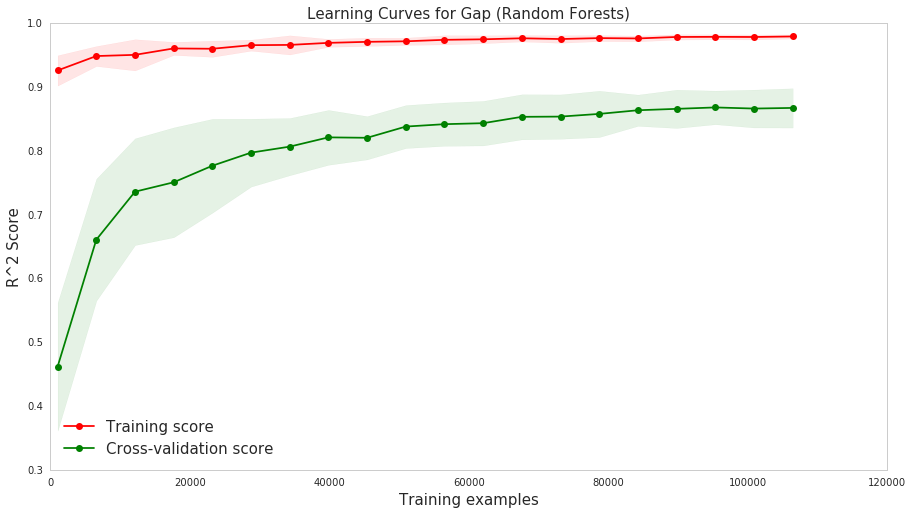

In [10]:
# Random Forests only supports MSE score for deciding splits
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=RandomForestRegressor(), alg_name="Random Forests")

The learning curve shows a steady rise until ~70K training examples.     
The rest of the curve is essentially flat for training with a slight rise in cross-validation.

## Feature Selection - Feature Importances

 1) demand_t-1                     0.741937
 2) supply_t-1                     0.126815
 3) demand_t-2                     0.023409
 4) supply_t-3                     0.018028
 5) demand_t-3                     0.015755
 6) tj_lvl1                        0.014352
 7) supply_t-2                     0.011661
 8) pollution                      0.011459
 9) tj_lvl2                        0.009003
10) tj_lvl3                        0.006132
11) temperature                    0.004237
12) poi_pc2                        0.002718
13) ts_2                           0.002314
14) ts_1                           0.002051
15) poi_pc1                        0.001779
16) ts_5                           0.001345
17) ts_4                           0.001222
18) wthr_1                         0.001139
19) ts_0                           0.001019
20) ts_3                           0.000913
21) wthr_0                         0.000796
22) wthr_2                         0.000719
23) wthr_3                      

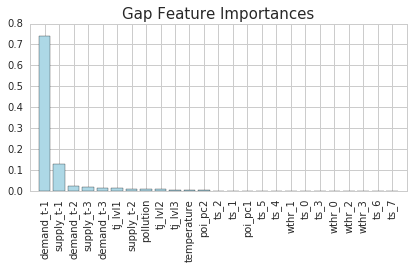

In [63]:
alg = RandomForestRegressor()
rfr = alg.fit(gX_train, gy_train)


# Plot Feature importances
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = gap_predictors
for f in range(gX_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Gap Feature Importances')
plt.bar(range(gX_train.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(gX_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, gX_train.shape[1]])
plt.tight_layout()
plt.show()

## Validation Curves

Validation Curves Runtime: 0h:03m:28s


n_estimators:       1    Train Score: 0.897 Test Score: 0.750
n_estimators:       3    Train Score: 0.953 Test Score: 0.839
n_estimators:      10    Train Score: 0.975 Test Score: 0.873
n_estimators:      30    Train Score: 0.980 Test Score: 0.881
n_estimators:     100    Train Score: 0.982 Test Score: 0.885
n_estimators:     300    Train Score: 0.982 Test Score: 0.886
n_estimators:    1000    Train Score: 0.983 Test Score: 0.886


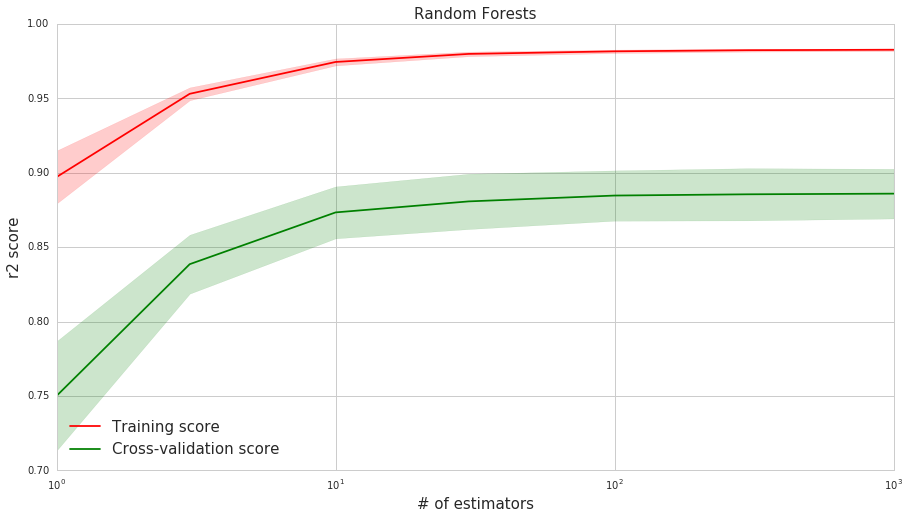

In [16]:
plot_validation_curve(estimator=RandomForestRegressor(), X=gX_train[:30000], y=gy_train[:30000], 
                      param_name='n_estimators', param_range=[1,3,10,30,100,300,1000], 
                      scoring='r2', plot_title='Random Forests', x_label='# of estimators', y_label='r2 score', 
                      n_jobs=-1)

Number of estimators has a significant impact on runtime. So we will avoid large number of estimators which do not provide much performance boost.    
Score flattens around 100 estimators - this is the number of estimators we will use for the hyperparameter grid search.

Validation Curves Runtime: 0h:00m:29s


max_features:       0    Train Score: 0.964 Test Score: 0.790
max_features:       0    Train Score: 0.976 Test Score: 0.849
max_features:       0    Train Score: 0.978 Test Score: 0.866
max_features:       0    Train Score: 0.978 Test Score: 0.868
max_features:       0    Train Score: 0.979 Test Score: 0.875
max_features:       0    Train Score: 0.980 Test Score: 0.874
max_features:       1    Train Score: 0.980 Test Score: 0.876


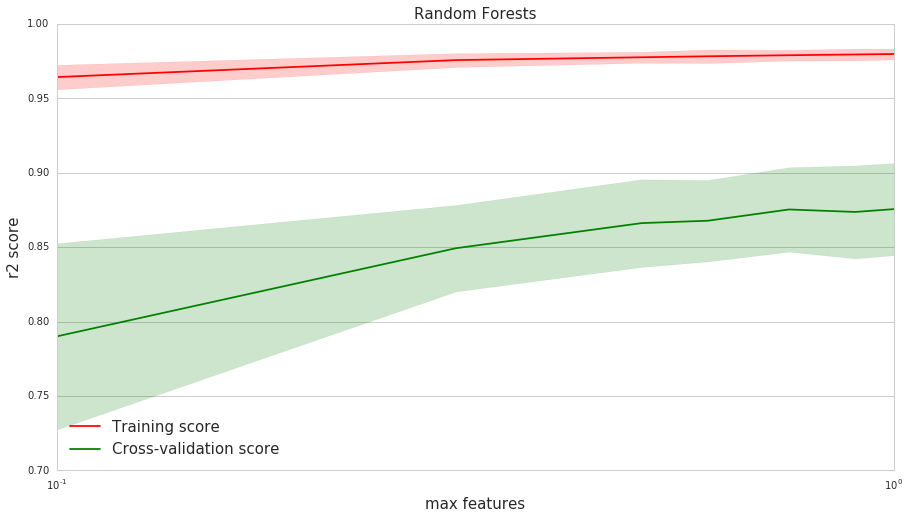

In [46]:
plot_validation_curve(estimator=RandomForestRegressor(), X=gX_train, y=gy_train, 
                      param_name='max_features', param_range=[0.1,0.3,0.5,0.6,0.75,0.9,1.0], 
                      scoring='r2', plot_title='Random Forests', x_label='max features', y_label='r2 score', 
                      n_jobs=-1)

Scores improve with a greater percentage of max features.   
Highest scores are observed when max features >= 0.75 - this is the range we will use for the hyperparameter grid search.

Validation Curves Runtime: 0h:00m:24s


max_depth:       1    Train Score: 0.463 Test Score: 0.348
max_depth:       3    Train Score: 0.780 Test Score: 0.721
max_depth:       5    Train Score: 0.884 Test Score: 0.833
max_depth:      10    Train Score: 0.958 Test Score: 0.867
max_depth:      30    Train Score: 0.979 Test Score: 0.874
max_depth:     100    Train Score: 0.980 Test Score: 0.874


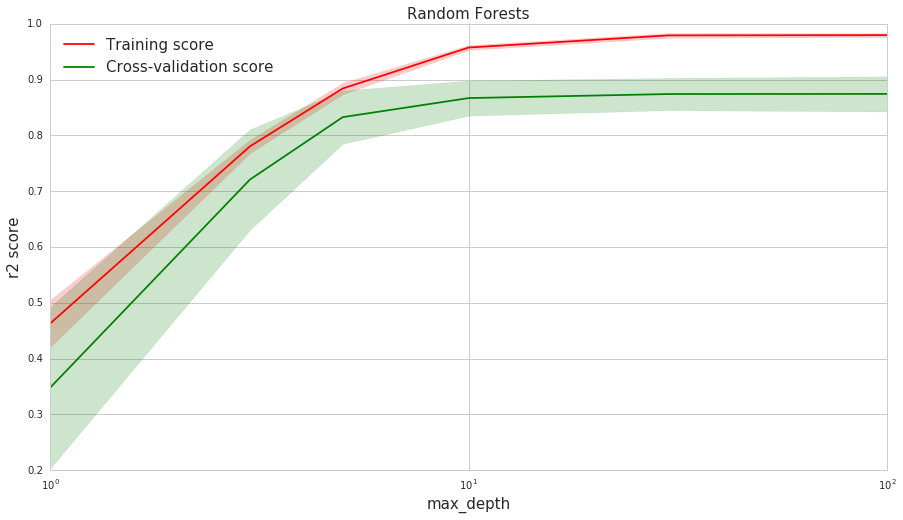

In [39]:
plot_validation_curve(estimator=RandomForestRegressor(), X=gX_train, y=gy_train, 
                      param_name='max_depth', param_range=[1,3,5,10,30,100], 
                      scoring='r2', plot_title='Random Forests', x_label='max_depth', y_label='r2 score', 
                      n_jobs=-1)

Underfitting is observed with max depth below 10.   
We will use max depth values near 10 for the hyperparameter grid search.

Validation Curves Runtime: 0h:00m:41s


min_samples_split:       1    Train Score: 0.980 Test Score: 0.875
min_samples_split:       3    Train Score: 0.978 Test Score: 0.875
min_samples_split:      10    Train Score: 0.953 Test Score: 0.860
min_samples_split:      30    Train Score: 0.918 Test Score: 0.837
min_samples_split:      50    Train Score: 0.903 Test Score: 0.835
min_samples_split:      75    Train Score: 0.893 Test Score: 0.832
min_samples_split:     100    Train Score: 0.884 Test Score: 0.827
min_samples_split:     300    Train Score: 0.760 Test Score: 0.689


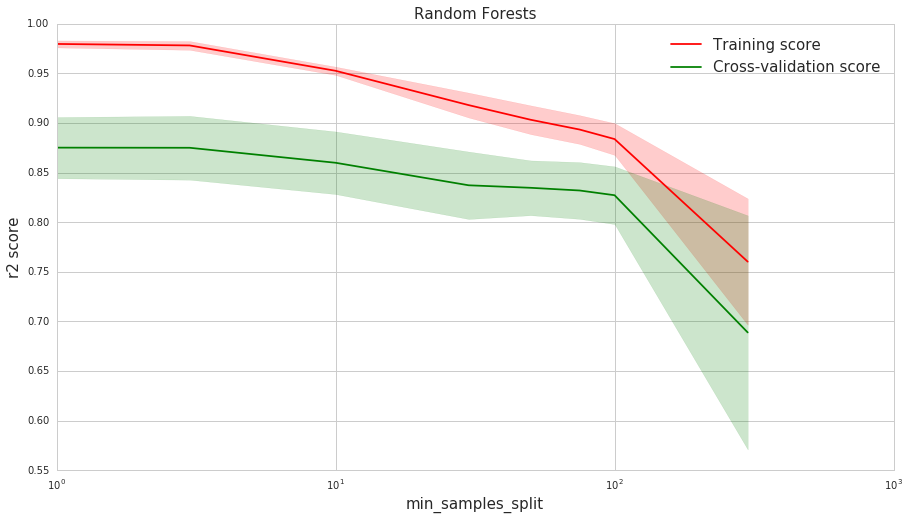

In [35]:
plot_validation_curve(estimator=RandomForestRegressor(), X=gX_train, y=gy_train, 
                      param_name='min_samples_split', param_range=[1,3,10,30,50,75,100,300], 
                      scoring='r2', plot_title='Random Forests', x_label='min_samples_split', y_label='r2 score', 
                      n_jobs=-1)

Overfitting is observed when min samples split is below 50. Underfitting is observed with min samples split above 100.   
We will use min samples split in the range of 50 to 75 for the hyperparameter grid search.

Validation Curves Runtime: 0h:00m:34s


min_samples_leaf:       1    Train Score: 0.980 Test Score: 0.875
min_samples_leaf:       3    Train Score: 0.958 Test Score: 0.864
min_samples_leaf:       5    Train Score: 0.932 Test Score: 0.853
min_samples_leaf:       7    Train Score: 0.904 Test Score: 0.827
min_samples_leaf:      10    Train Score: 0.856 Test Score: 0.784
min_samples_leaf:      30    Train Score: 0.740 Test Score: 0.714
min_samples_leaf:     100    Train Score: 0.604 Test Score: 0.597


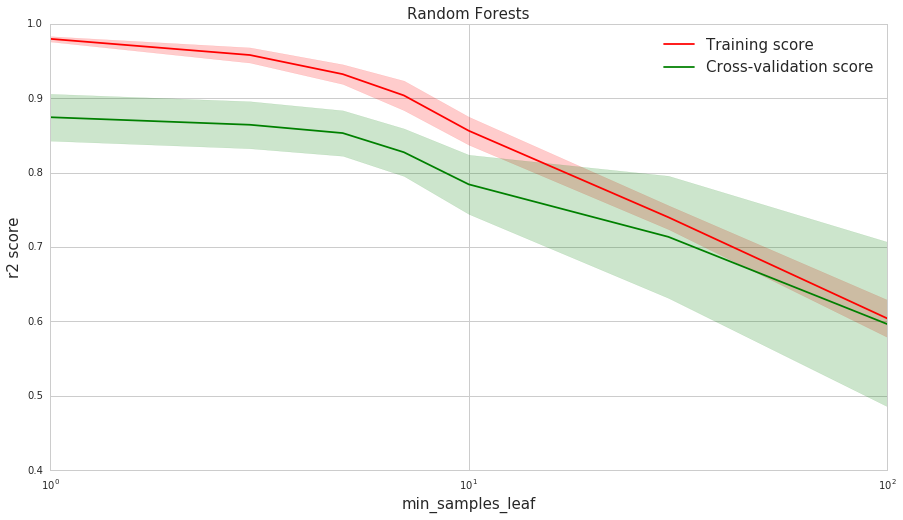

In [34]:
plot_validation_curve(estimator=RandomForestRegressor(), X=gX_train, y=gy_train, 
                      param_name='min_samples_leaf', param_range=[1,3,5,7,10,30,100], 
                      scoring='r2', plot_title='Random Forests', x_label='min_samples_leaf', y_label='r2 score', 
                      n_jobs=-1)

Overfitting is observed when min samples per leaf is low and underfitting is observed for higher values.
We will use max depth in the range of 5 for the hyperparameter grid search as it seems to perform a reasonably high score without too much overfitting.

## Hyper Parameter Selection
Use parameter values picked using validation curves. Add a additional values near the optimal value for grid selection. 

GridSearchCV Runtime: 1h:09m:19s


All CV Scores: [ 0.8336329   0.82554492  0.77973056  0.59022677 -0.11754487]
Mean CV Score: 0.582 +/- 0.361
Best Estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features=1.0, max_leaf_nodes=None, min_samples_leaf=4,
           min_samples_split=50, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
Learning Curves Runtime: 0h:24m:17s


Train Size:    1064 Train Score: 0.543 Test Score: 0.333
Train Size:    6610 Train Score: 0.701 Test Score: 0.562
Train Size:   12157 Train Score: 0.738 Test Score: 0.634
Train Size:   17703 Train Score: 0.769 Test Score: 0.664
Train Size:   23249 Train Score: 0.783 Test Score: 0.704
Train Size:   28795 Train Score: 0.799 Test Score: 0.727
Train Size:   34342 Train Score: 0.817 Test Score: 0.747
Train Size:   39888 Train Score: 0.829 Test Score: 0.765
Train Size:   45434 Train Score: 

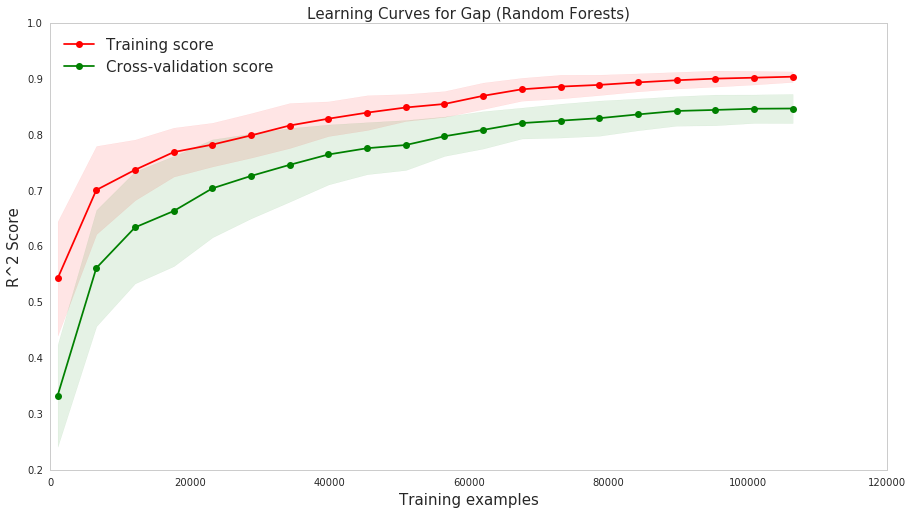



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	173.35		0.91		0.38
TEST      	314.44		0.86		0.39


In [19]:
# Use GridSearchCV - RandomForestRegressor
# Specify parameters
param_grid = {'n_estimators'      : [75, 100, 200],
              'max_features'      : [0.75, 0.9, 1.0],
              'max_depth'         : [9, 10, 11],
              'min_samples_split' : [50, 60, 75],
              'min_samples_leaf'  : [4, 5, 6],
              'random_state'      : [0]}

alg = RandomForestRegressor()

# Only mse is supported for the RandomForestRegressor
# Use R^2 as scoring function for GridSearchCV, cross_val_score
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='Random Forests', param_grid=param_grid, scoring_func='r2')

# K NEAREST NEIGHBORS

## Learning Curves

Learning Curves Runtime: 0h:26m:32s


Train Size:    1064 Train Score: 0.574 Test Score: 0.319
Train Size:    6610 Train Score: 0.704 Test Score: 0.538
Train Size:   12157 Train Score: 0.751 Test Score: 0.608
Train Size:   17703 Train Score: 0.787 Test Score: 0.641
Train Size:   23249 Train Score: 0.797 Test Score: 0.680
Train Size:   28795 Train Score: 0.805 Test Score: 0.697
Train Size:   34342 Train Score: 0.815 Test Score: 0.719
Train Size:   39888 Train Score: 0.825 Test Score: 0.732
Train Size:   45434 Train Score: 0.836 Test Score: 0.743
Train Size:   50981 Train Score: 0.847 Test Score: 0.753
Train Size:   56527 Train Score: 0.852 Test Score: 0.768
Train Size:   62073 Train Score: 0.864 Test Score: 0.773
Train Size:   67619 Train Score: 0.874 Test Score: 0.783
Train Size:   73166 Train Score: 0.876 Test Score: 0.785
Train Size:   78712 Train Score: 0.880 Test Score: 0.789
Train Size:   84258 Train Score: 0.885 Test Score: 0.792
Train Size:   89805 Train Score: 0.886 Test Score:

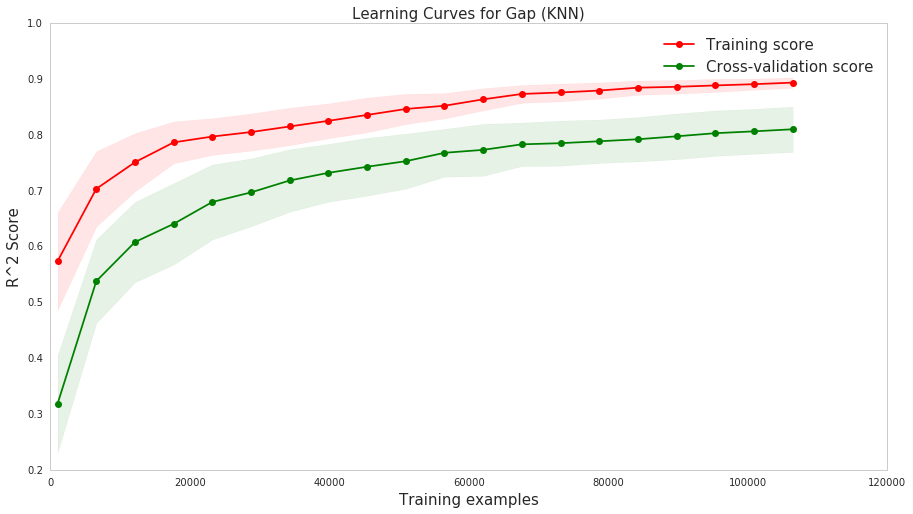

In [29]:
# KNN defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=KNeighborsRegressor(), alg_name="KNN")

The learning curve shows a steady rise with training examples that slows down above 70K examples.

## Validation Curves

### Number of neighbors w/ uniform weights

Validation Curves Runtime: 0h:11m:33s


n_neighbors:       3    Train Score: 0.928 Test Score: 0.824
n_neighbors:       5    Train Score: 0.892 Test Score: 0.817
n_neighbors:       7    Train Score: 0.866 Test Score: 0.801
n_neighbors:      10    Train Score: 0.836 Test Score: 0.778
n_neighbors:      20    Train Score: 0.756 Test Score: 0.719
n_neighbors:      30    Train Score: 0.705 Test Score: 0.679


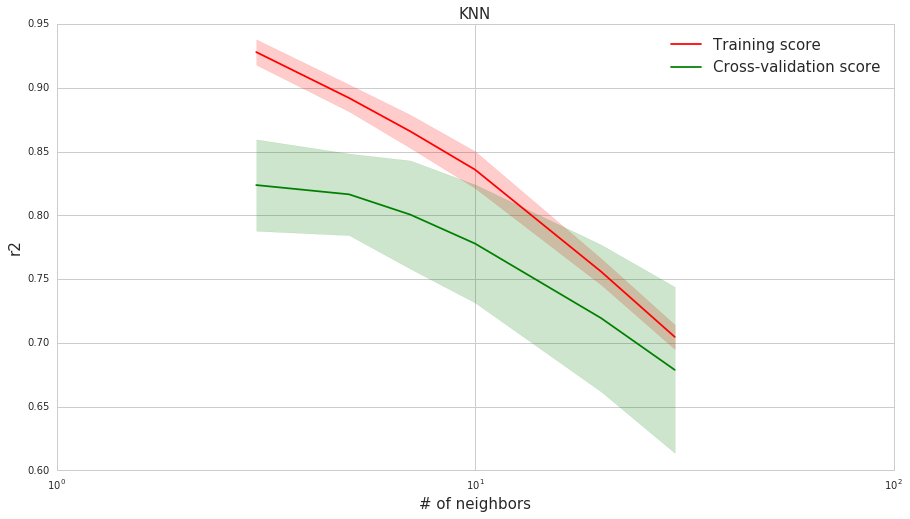

In [48]:
plot_validation_curve(estimator=KNeighborsRegressor(weights='uniform'), X=gX_train, y=gy_train, 
                      param_name='n_neighbors', param_range=[3,5,7,10,20,30], 
                      scoring='r2', plot_title='KNN', x_label='# of neighbors', y_label='r2', 
                      n_jobs=-1)

Underfitting is observed when number of neighbors rises above 7.    
We can use number of neighbors in the 5-7 range for the hyperparameter grid search.

### Number of neighbors w/ distance weights

Validation Curves Runtime: 0h:10m:53s


n_neighbors:       3    Train Score: 1.000 Test Score: 0.832
n_neighbors:       5    Train Score: 1.000 Test Score: 0.827
n_neighbors:       7    Train Score: 1.000 Test Score: 0.816
n_neighbors:      10    Train Score: 1.000 Test Score: 0.802
n_neighbors:      20    Train Score: 1.000 Test Score: 0.760
n_neighbors:      30    Train Score: 1.000 Test Score: 0.726


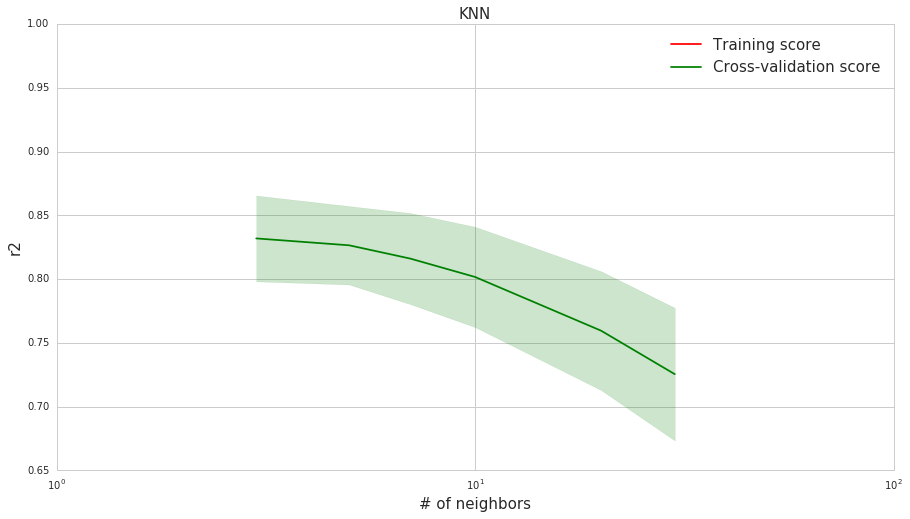

In [20]:
plot_validation_curve(estimator=KNeighborsRegressor(weights='distance'), X=gX_train, y=gy_train, 
                      param_name='n_neighbors', param_range=[3,5,7,10,20,30], 
                      scoring='r2', plot_title='KNN', x_label='# of neighbors', y_label='r2', 
                      n_jobs=-1)

Using 'distance' for weights parameter leads to overfitting. So, we will choose 'uniform'.

## Hyper Parameter Selection

GridSearchCV Runtime: 0h:03m:24s


All CV Scores: [ 0.58665213  0.75551623  0.6552995   0.51993001 -0.82018995]
Mean CV Score: 0.339 +/- 0.585
Best Estimator:
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
Learning Curves Runtime: 0h:30m:40s


Train Size:    1064 Train Score: 0.494 Test Score: 0.290
Train Size:    6610 Train Score: 0.654 Test Score: 0.513
Train Size:   12157 Train Score: 0.707 Test Score: 0.588
Train Size:   17703 Train Score: 0.741 Test Score: 0.622
Train Size:   23249 Train Score: 0.751 Test Score: 0.659
Train Size:   28795 Train Score: 0.762 Test Score: 0.678
Train Size:   34342 Train Score: 0.777 Test Score: 0.697
Train Size:   39888 Train Score: 0.788 Test Score: 0.712
Train Size:   45434 Train Score: 0.799 Test Score: 0.722
Train Size:   50981 Train Score: 0.809 Test Score: 0.732
Train Size:   56527 Train Score: 0.815 Test Score: 0.747
Train Size:   6

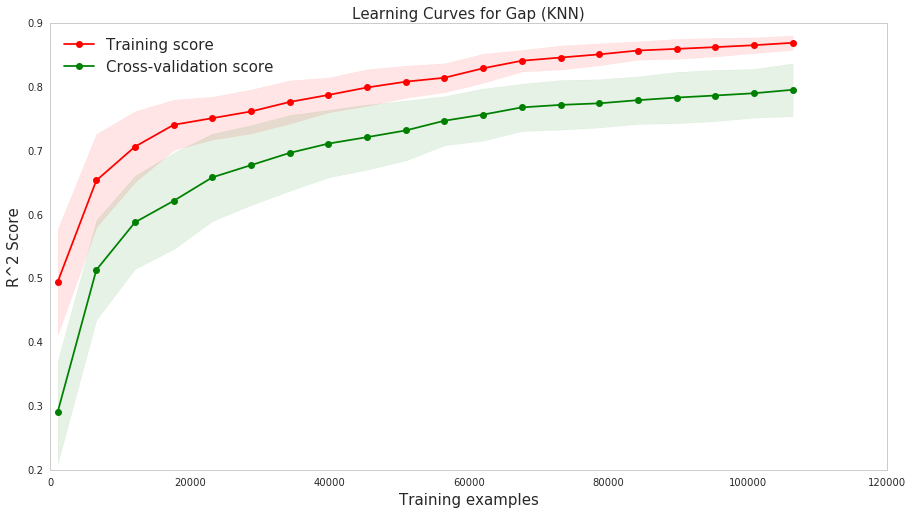



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	225.96		0.88		0.42
TEST      	594.89		0.74		0.56


In [11]:
# Specify parameters
param_grid = {'n_neighbors' : [5, 7],
              'weights'     : ['uniform'],
              'metric'      : ['euclidean', 'minkowski']}

alg = KNeighborsRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='KNN', param_grid=param_grid, scoring_func='r2')

# SUPPORT VECTOR MACHINES

## Learning Curves

### RBF (default) Kernel

Learning Curves Runtime: 1h:43m:32s


Train Size:    1064 Train Score: 0.377 Test Score: 0.166
Train Size:    6610 Train Score: 0.467 Test Score: 0.329
Train Size:   12157 Train Score: 0.483 Test Score: 0.390
Train Size:   17703 Train Score: 0.508 Test Score: 0.428
Train Size:   23249 Train Score: 0.494 Test Score: 0.453
Train Size:   28795 Train Score: 0.495 Test Score: 0.470
Train Size:   34342 Train Score: 0.511 Test Score: 0.487
Train Size:   39888 Train Score: 0.503 Test Score: 0.500
Train Size:   45434 Train Score: 0.515 Test Score: 0.511
Train Size:   50981 Train Score: 0.524 Test Score: 0.519
Train Size:   56527 Train Score: 0.521 Test Score: 0.526
Train Size:   62073 Train Score: 0.515 Test Score: 0.532
Train Size:   67619 Train Score: 0.511 Test Score: 0.538
Train Size:   73166 Train Score: 0.515 Test Score: 0.544
Train Size:   78712 Train Score: 0.522 Test Score: 0.548
Train Size:   84258 Train Score: 0.527 Test Score: 0.554
Train Size:   89805 Train Score: 0.528 Test Score:

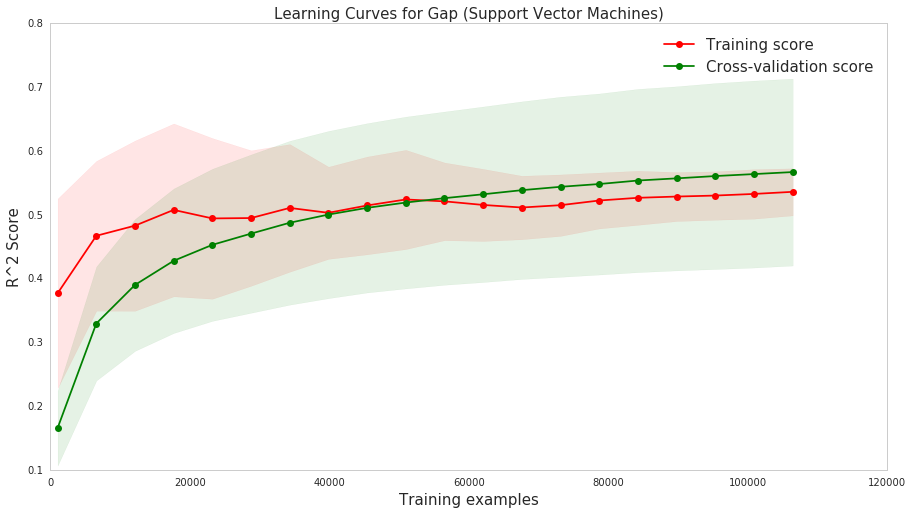

In [31]:
# SVM defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=SVR(), alg_name="Support Vector Machines")

Model displays underfitting and is unable to rise above 0.54 for training score.

### Linear Kernel

Learning Curves Runtime: 3h:54m:42s


Train Size:    1064 Train Score: 0.872 Test Score: 0.844
Train Size:    6610 Train Score: 0.877 Test Score: 0.867
Train Size:   12157 Train Score: 0.887 Test Score: 0.868
Train Size:   17703 Train Score: 0.884 Test Score: 0.869
Train Size:   23249 Train Score: 0.887 Test Score: 0.869
Train Size:   28795 Train Score: 0.886 Test Score: 0.869
Train Size:   34342 Train Score: 0.887 Test Score: 0.869
Train Size:   39888 Train Score: 0.887 Test Score: 0.870
Train Size:   45434 Train Score: 0.884 Test Score: 0.870
Train Size:   50981 Train Score: 0.883 Test Score: 0.869
Train Size:   56527 Train Score: 0.884 Test Score: 0.870
Train Size:   62073 Train Score: 0.888 Test Score: 0.870
Train Size:   67619 Train Score: 0.891 Test Score: 0.870
Train Size:   73166 Train Score: 0.890 Test Score: 0.870
Train Size:   78712 Train Score: 0.889 Test Score: 0.870
Train Size:   84258 Train Score: 0.891 Test Score: 0.870
Train Size:   89805 Train Score: 0.890 Test Score:

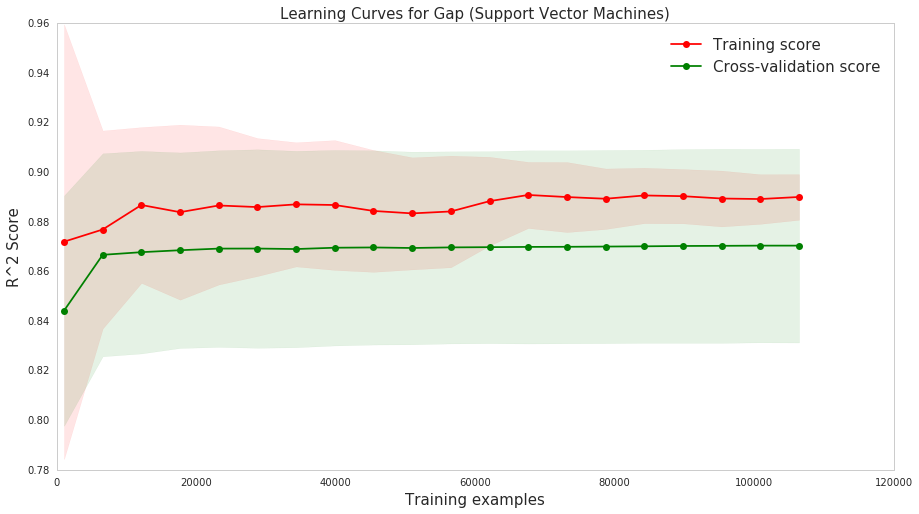

In [49]:
# SVM defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=SVR(kernel='linear'), alg_name="Support Vector Machines")

Linear kernel improves performance. The kernel's performance maxes out with just ~10K examples which is an indication of high bias. Tuning the 'C' parameter may help with this issue.    
However, runtime is much higher than other algorithms. Try setting the cache_size to a higher value (>=1000MB) to reduce runtime.       

### Poly Kernel

In [ ]:
# SVM defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=SVR(kernel='poly'), alg_name="Support Vector Machines")

## Validation Curves

Validation Curves Runtime: 0h:47m:20s


C:       0    Train Score: 0.885 Test Score: 0.885
C:       0    Train Score: 0.886 Test Score: 0.885
C:       0    Train Score: 0.886 Test Score: 0.886
C:       0    Train Score: 0.886 Test Score: 0.886
C:       1    Train Score: 0.886 Test Score: 0.886


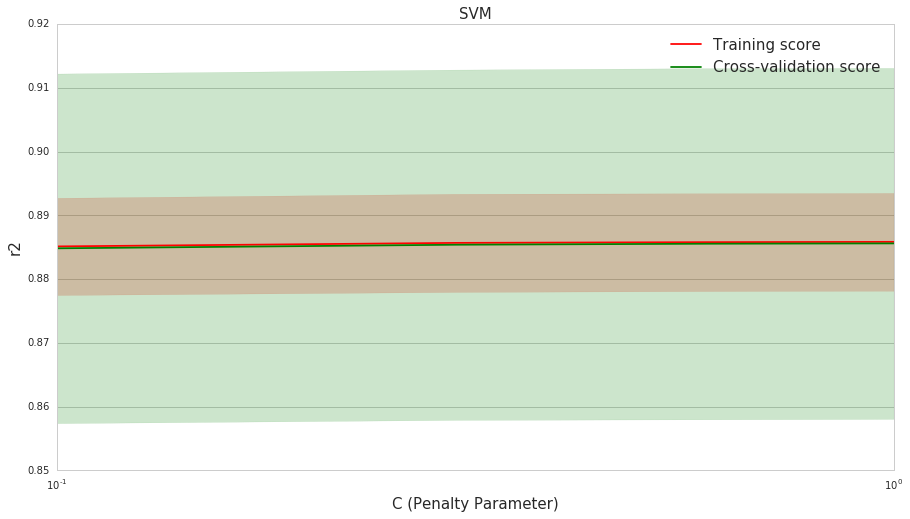

In [10]:
plot_validation_curve(estimator=SVR(kernel='linear',cache_size=4000), X=gX_train, y=gy_train, 
                      param_name='C', param_range=[0.1,0.3,0.6,0.9,1.0], 
                      scoring='r2', plot_title='SVM', x_label='C (Penalty Parameter)', y_label='r2', 
                      n_jobs=10)

Varying the penalty parameter does not have any impact on the train / cross-validation scores.

## Hyper Parameter Selection

GridSearchCV Runtime: 2h:12m:27s


All CV Scores: [ 0.86376654  0.84270377  0.80591031  0.90920376 -0.3866627 ]
Mean CV Score: 0.607 +/- 0.498
Best Estimator:
SVR(C=1.0, cache_size=1000, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Learning Curves Runtime: 2h:03m:02s


Train Size:    1064 Train Score: 0.872 Test Score: 0.844
Train Size:    6610 Train Score: 0.877 Test Score: 0.867
Train Size:   12157 Train Score: 0.887 Test Score: 0.868
Train Size:   17703 Train Score: 0.884 Test Score: 0.869
Train Size:   23249 Train Score: 0.887 Test Score: 0.869
Train Size:   28795 Train Score: 0.886 Test Score: 0.869
Train Size:   34342 Train Score: 0.887 Test Score: 0.869
Train Size:   39888 Train Score: 0.887 Test Score: 0.870
Train Size:   45434 Train Score: 0.884 Test Score: 0.870
Train Size:   50981 Train Score: 0.883 Test Score: 0.869
Train Size:   56527 Train Score: 0.884 Test Score: 0.870
Train Size:   62073 Train 

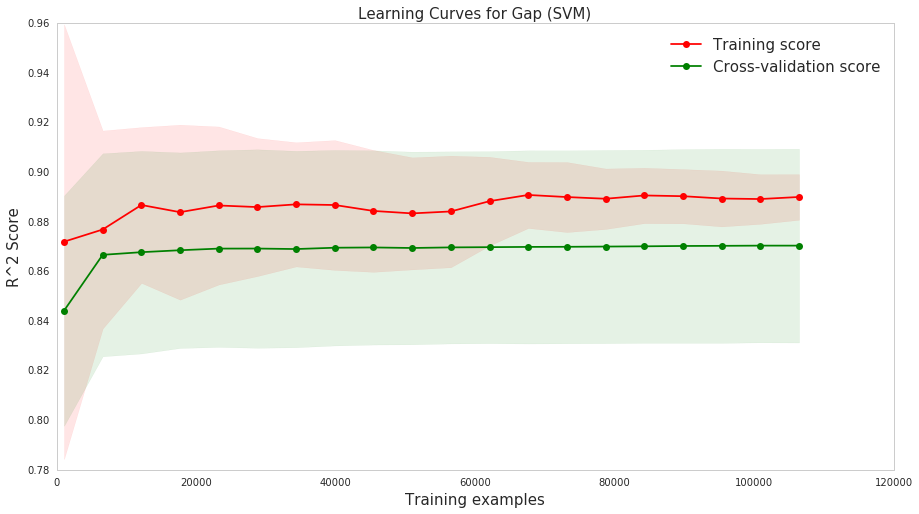



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	212.98		0.89		0.43
TEST      	300.95		0.87		0.42


In [20]:
# Specify parameters
param_grid = {'kernel'      : ['linear', 'poly'],
              'degree'      : [2, 3],
              'C'           : [0.1, 0.6, 1.0],
              'cache_size'  : [1000]  # to improve runtime
             }

alg = SVR()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='SVM', param_grid=param_grid, scoring_func='r2')

# LINEAR REGRESSION

## Learning Curves

Learning Curves Runtime: 0h:00m:14s


Train Size:    1064 Train Score: 0.897 Test Score: 0.843
Train Size:   22140 Train Score: 0.898 Test Score: 0.876
Train Size:   43216 Train Score: 0.895 Test Score: 0.878
Train Size:   64292 Train Score: 0.899 Test Score: 0.879
Train Size:   85368 Train Score: 0.900 Test Score: 0.880
Train Size:  106444 Train Score: 0.900 Test Score: 0.880


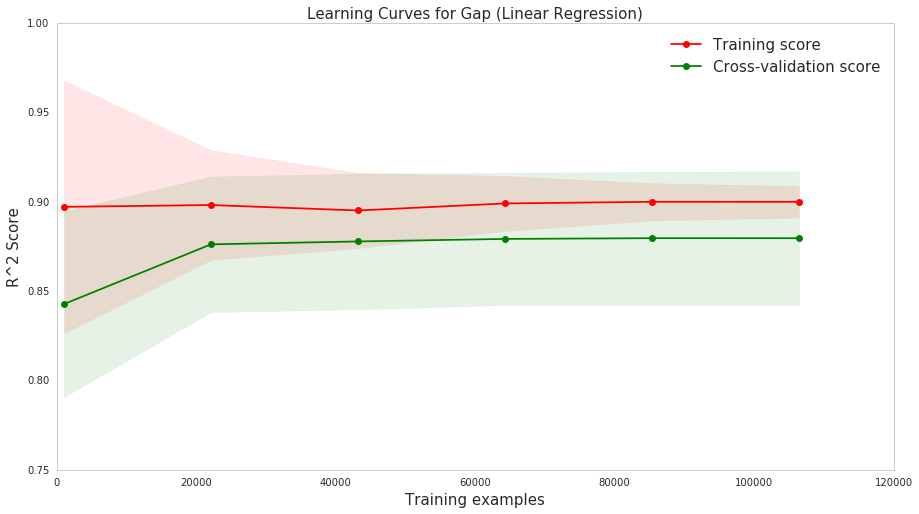

In [63]:
# Linear Regression defaults to R^2 score
generate_learningcurves(sparse=True, gX_train=gX_train, gy_train=gy_train,
                        alg=LinearRegression(), alg_name="Linear Regression")

Linear regression delivers good performance with very fast runtimes. Performance maxes out with just ~10K examples which is an indication of bias. Performing feature selection may help with this issue.  

## Feature Selection - Recursive Feature Elimination

### Run RFECV

In [18]:
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5, scoring='r2')
selector = selector.fit(gX_train, gy_train)
print '\nMask of selected features:\n', selector.support_ 
print '\nFeature ranking:\n', selector.ranking_


Mask of selected features:
[ True False False  True False False False False False False False False
 False False False False False False False False False False False False
 False]

Feature ranking:
[ 1  2  4  1  3  8  6 14  7  5 13 22 12 15 23 18 21 16 17 20 19 24  9 10 11]


Here are the top 10 ranking features from RFE:
1. demand_t-1, supply_t-1
2. demand_t-2
3. supply_t-2
4. demand_t-3
5. tj_lvl2
6. poi_pc1
7. tj_lvl1
8. supply_t-3
9. wthr_1
10. wthr_2

### Rerun learning curves with top 2 features

Learning Curves Runtime: 0h:00m:05s


Train Size:    1064 Train Score: 0.873 Test Score: 0.847
Train Size:   22140 Train Score: 0.885 Test Score: 0.863
Train Size:   43216 Train Score: 0.880 Test Score: 0.864
Train Size:   64292 Train Score: 0.885 Test Score: 0.865
Train Size:   85368 Train Score: 0.886 Test Score: 0.865
Train Size:  106444 Train Score: 0.886 Test Score: 0.865


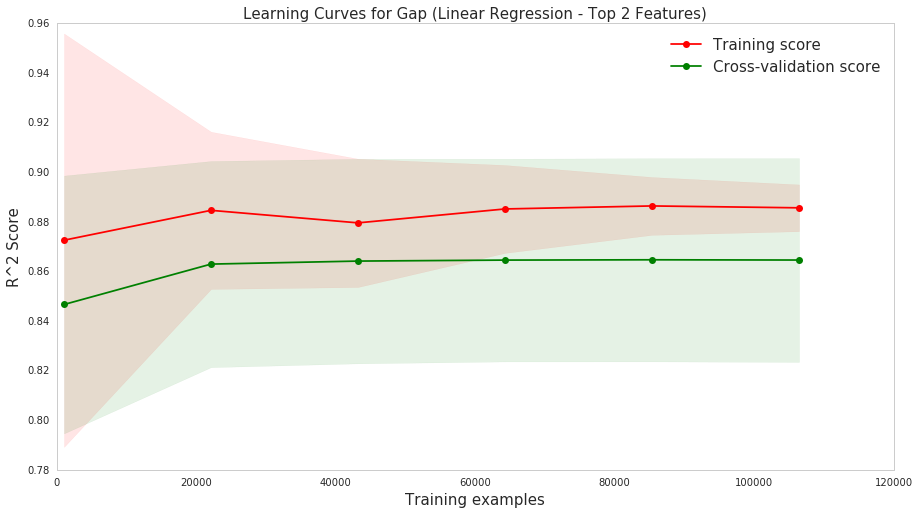

In [55]:
# Select demand_t-1 [0], supply_t-1 [3]
generate_learningcurves(sparse=True, gX_train=gX_train[:,[0,3]], gy_train=gy_train,
                        alg=LinearRegression(), alg_name="Linear Regression - Top 2 Features")

### Rerun learning curves with top 4 features

Learning Curves Runtime: 0h:00m:06s


Train Size:    1064 Train Score: 0.880 Test Score: 0.855
Train Size:   22140 Train Score: 0.897 Test Score: 0.877
Train Size:   43216 Train Score: 0.894 Test Score: 0.878
Train Size:   64292 Train Score: 0.898 Test Score: 0.880
Train Size:   85368 Train Score: 0.899 Test Score: 0.880
Train Size:  106444 Train Score: 0.899 Test Score: 0.880


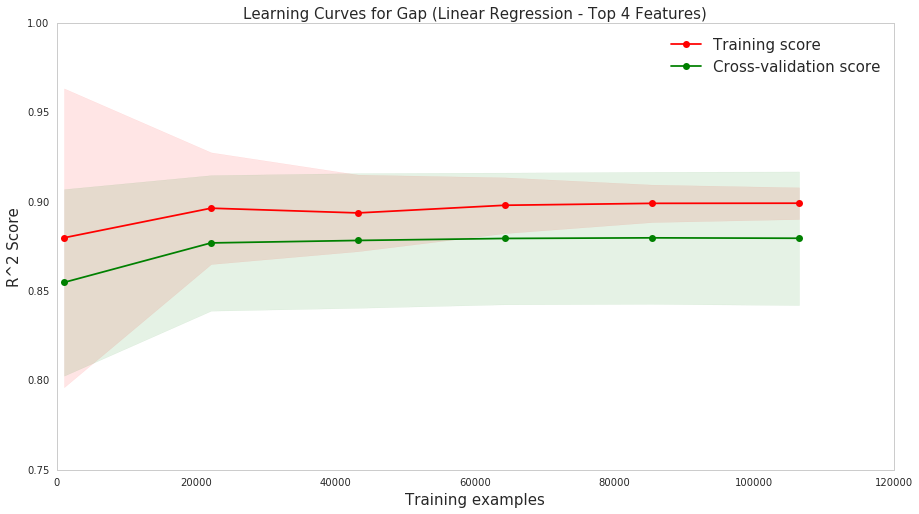

In [56]:
# Select demand_t-1 [0], supply_t-1 [3], demand_t-2 [1], supply_t-2 [4]
generate_learningcurves(sparse=True, gX_train=gX_train[:,[0,1,3,4]], gy_train=gy_train,
                        alg=LinearRegression(), alg_name="Linear Regression - Top 4 Features")

### Rerun learning curves with top 6 features

Learning Curves Runtime: 0h:00m:08s


Train Size:    1064 Train Score: 0.884 Test Score: 0.852
Train Size:   22140 Train Score: 0.897 Test Score: 0.877
Train Size:   43216 Train Score: 0.894 Test Score: 0.878
Train Size:   64292 Train Score: 0.898 Test Score: 0.880
Train Size:   85368 Train Score: 0.899 Test Score: 0.880
Train Size:  106444 Train Score: 0.899 Test Score: 0.880


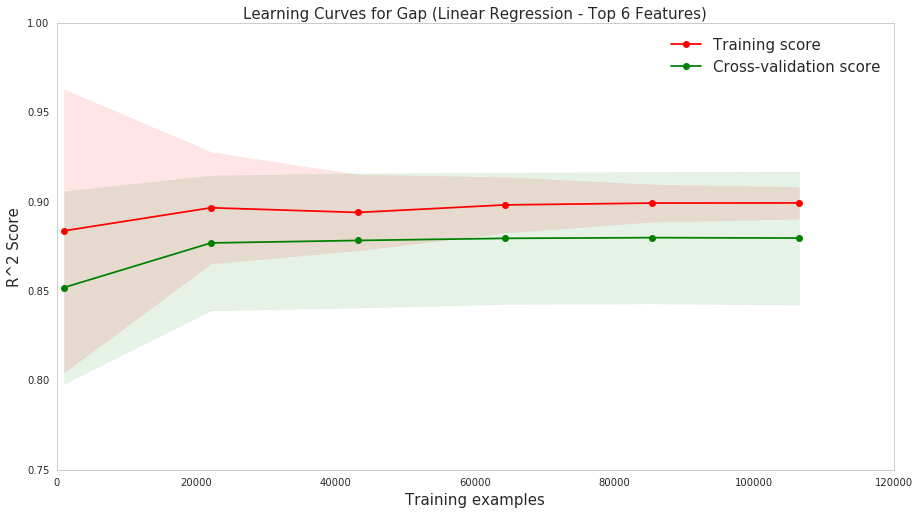

In [57]:
# Select demand_t-1 [0], supply_t-1 [3], demand_t-2 [1], supply_t-2 [4], tj_lvl2 [9], poi_pc1 [6]
generate_learningcurves(sparse=True, gX_train=gX_train[:,[0,1,3,4,9,6]], gy_train=gy_train,
                        alg=LinearRegression(), alg_name="Linear Regression - Top 6 Features")

Based on the learning curve experiments, we conclude that the top 4 features are sufficient to achieve the best performance with linear regression. The performance with just the top 4 features matches the results from using all the features.

# GRADIENT BOOSTED TREES

## Learning Curves

Learning Curves Runtime: 0h:02m:18s


Train Size:    1064 Train Score: 0.993 Test Score: 0.492
Train Size:   22140 Train Score: 0.952 Test Score: 0.799
Train Size:   43216 Train Score: 0.942 Test Score: 0.836
Train Size:   64292 Train Score: 0.938 Test Score: 0.852
Train Size:   85368 Train Score: 0.935 Test Score: 0.866
Train Size:  106444 Train Score: 0.933 Test Score: 0.873


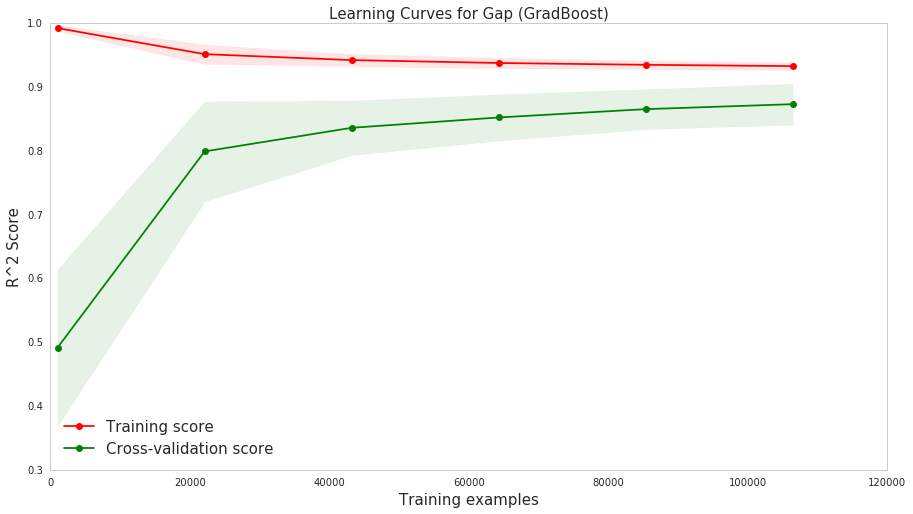

In [10]:
# Gradient Boosting defaults to Least Squares as the loss function
alg = GradientBoostingRegressor()
generate_learningcurves(sparse=True, gX_train=gX_train, gy_train=gy_train,
                        alg=alg, alg_name="GradBoost")

## Feature Selection - Feature Importances

 1) demand_t-1                     0.418205
 2) supply_t-1                     0.211970
 3) demand_t-3                     0.057138
 4) demand_t-2                     0.042869
 5) temperature                    0.041649
 6) tj_lvl2                        0.041591
 7) supply_t-3                     0.037991
 8) pollution                      0.028570
 9) supply_t-2                     0.022850
10) ts_1                           0.022569
11) wthr_1                         0.018076
12) poi_pc2                        0.011945
13) tj_lvl3                        0.010910
14) tj_lvl1                        0.007851
15) ts_4                           0.007088
16) ts_2                           0.005832
17) ts_5                           0.005476
18) ts_6                           0.003001
19) poi_pc1                        0.002671
20) ts_0                           0.001724
21) ts_7                           0.000025
22) ts_3                           0.000000
23) wthr_2                      

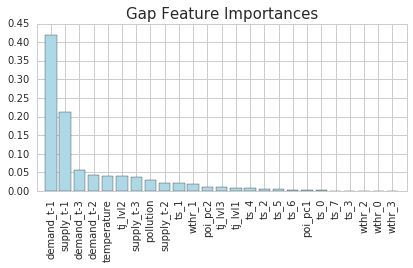

In [53]:
alg = GradientBoostingRegressor()
rfr = alg.fit(gX_train, gy_train)


# Plot Feature importances
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = gap_predictors
for f in range(gX_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [feature_labels[i] for i in indices]
    
plt.title('Gap Feature Importances')
plt.bar(range(gX_train.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(gX_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, gX_train.shape[1]])
plt.tight_layout()
plt.show()

### Rerun learning curves with top 2 features

Learning Curves Runtime: 0h:02m:08s


Train Size:    1064 Train Score: 0.988 Test Score: 0.560
Train Size:   22140 Train Score: 0.937 Test Score: 0.801
Train Size:   43216 Train Score: 0.927 Test Score: 0.837
Train Size:   64292 Train Score: 0.923 Test Score: 0.843
Train Size:   85368 Train Score: 0.920 Test Score: 0.852
Train Size:  106444 Train Score: 0.918 Test Score: 0.856


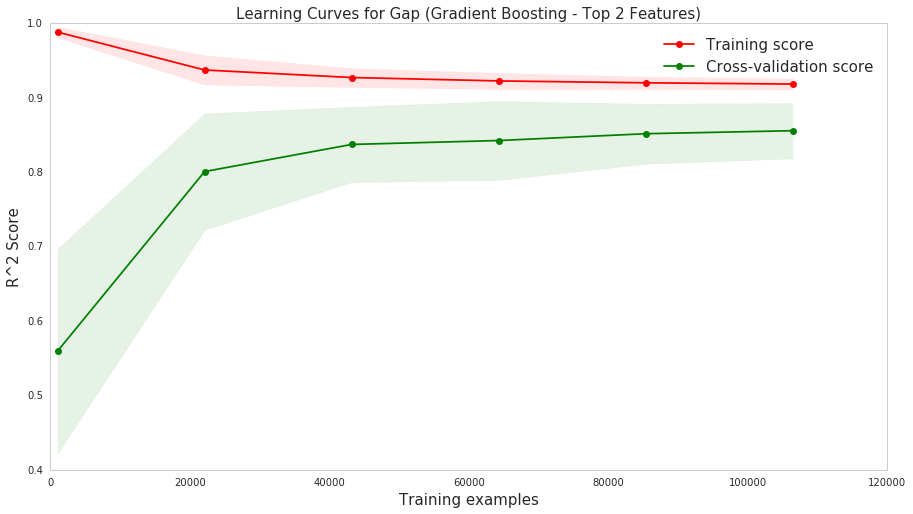

In [54]:
# Select demand_t-1 [0], supply_t-1 [3]
generate_learningcurves(sparse=True, gX_train=gX_train[:,[0,3]], gy_train=gy_train,
                        alg=GradientBoostingRegressor(), alg_name="Gradient Boosting - Top 2 Features")

### Rerun learning curves with top 4 features

Learning Curves Runtime: 0h:03m:06s


Train Size:    1064 Train Score: 0.991 Test Score: 0.524
Train Size:   22140 Train Score: 0.948 Test Score: 0.794
Train Size:   43216 Train Score: 0.939 Test Score: 0.822
Train Size:   64292 Train Score: 0.935 Test Score: 0.834
Train Size:   85368 Train Score: 0.932 Test Score: 0.850
Train Size:  106444 Train Score: 0.929 Test Score: 0.856


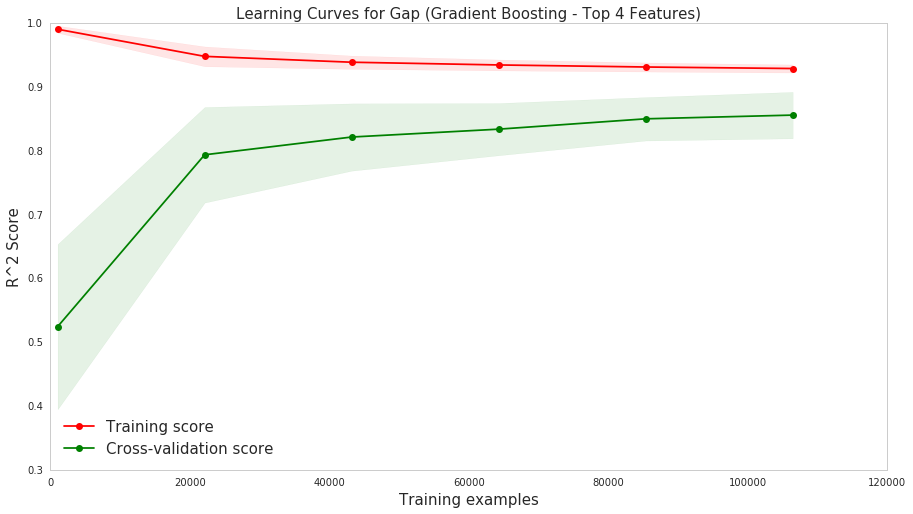

In [58]:
# Select demand_t-1 [0], supply_t-1 [3], demand_t-3 [2], demand_t-2 [1] 
generate_learningcurves(sparse=True, gX_train=gX_train[:,[0,3,2,1]], gy_train=gy_train,
                        alg=GradientBoostingRegressor(), alg_name="Gradient Boosting - Top 4 Features")

### Rerun learning curves with top 8 features

Learning Curves Runtime: 0h:05m:14s


Train Size:    1064 Train Score: 0.992 Test Score: 0.517
Train Size:   22140 Train Score: 0.951 Test Score: 0.801
Train Size:   43216 Train Score: 0.941 Test Score: 0.831
Train Size:   64292 Train Score: 0.937 Test Score: 0.849
Train Size:   85368 Train Score: 0.933 Test Score: 0.857
Train Size:  106444 Train Score: 0.931 Test Score: 0.867


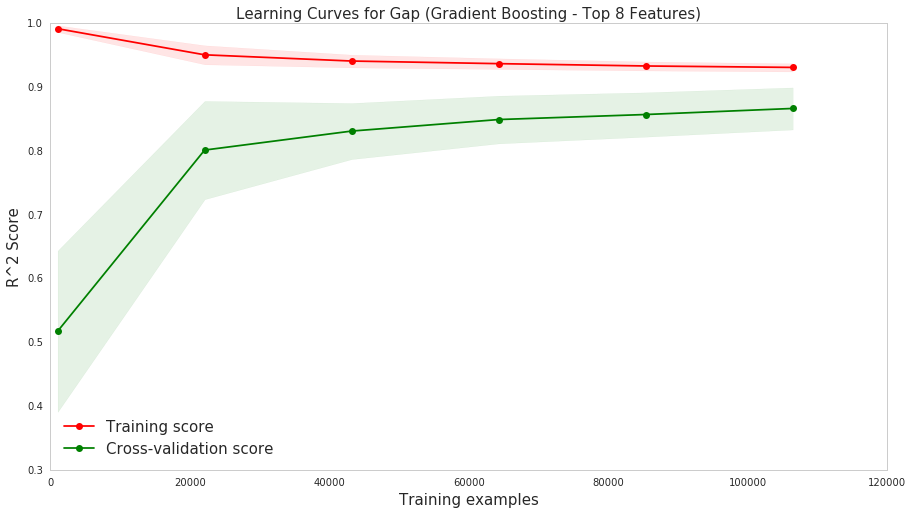

In [61]:
# Select demand_t-1 [0], supply_t-1 [3], demand_t-3 [2], demand_t-2 [1], temperature [20], tj_lvl2 [9], supply_t-3 [5], 
# pollution [19] 
generate_learningcurves(sparse=True, gX_train=gX_train[:,[0,3,2,1,20,9,5,19]], gy_train=gy_train,
                        alg=GradientBoostingRegressor(), alg_name="Gradient Boosting - Top 8 Features")

### Rerun learning curves with top 12 features

Learning Curves Runtime: 0h:06m:39s


Train Size:    1064 Train Score: 0.992 Test Score: 0.509
Train Size:   22140 Train Score: 0.951 Test Score: 0.801
Train Size:   43216 Train Score: 0.942 Test Score: 0.834
Train Size:   64292 Train Score: 0.938 Test Score: 0.850
Train Size:   85368 Train Score: 0.934 Test Score: 0.862
Train Size:  106444 Train Score: 0.932 Test Score: 0.869


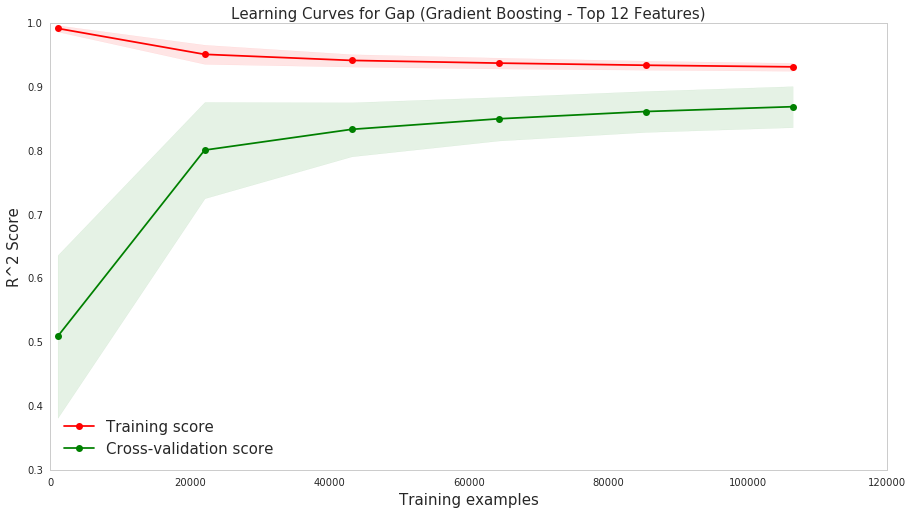

In [64]:
# Select demand_t-1 [0], supply_t-1 [3], demand_t-3 [2], demand_t-2 [1], temperature [20], tj_lvl2 [9], supply_t-3 [5], 
# pollution [19], supply_t-2 [4], ts_1 [12], wthr_1 [22], poi_pc2[7] 
generate_learningcurves(sparse=True, gX_train=gX_train[:,[0,3,2,1,20,9,5,19,4,12,22,7]], gy_train=gy_train,
                        alg=GradientBoostingRegressor(), alg_name="Gradient Boosting - Top 12 Features")

Based on the learning curve experiments, we conclude that the top 12 features are sufficient to capture most of the performance with gradient boosting.

## Validation Curves

Validation Curves Runtime: 0h:03m:08s


learning_rate:       0    Train Score: 0.693 Test Score: 0.641
learning_rate:       0    Train Score: 0.873 Test Score: 0.823
learning_rate:       0    Train Score: 0.904 Test Score: 0.853
learning_rate:       0    Train Score: 0.919 Test Score: 0.865
learning_rate:       0    Train Score: 0.931 Test Score: 0.877
learning_rate:       0    Train Score: 0.956 Test Score: 0.885
learning_rate:       0    Train Score: 0.964 Test Score: 0.879
learning_rate:       0    Train Score: 0.967 Test Score: 0.850
learning_rate:       1    Train Score: 0.967 Test Score: 0.828


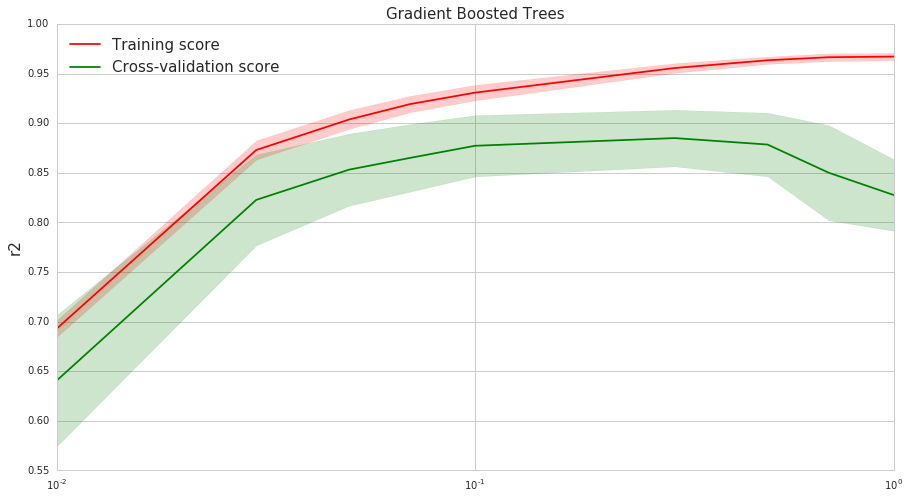

In [13]:
plot_validation_curve(estimator=GradientBoostingRegressor(), X=gX_train, y=gy_train, 
                      param_name='learning_rate', param_range=[0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,1], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='learning rate', y_label='r2', 
                      n_jobs=-1)

Validation Curves Runtime: 0h:05m:25s


n_estimators:      10    Train Score: 0.703 Test Score: 0.650
n_estimators:      30    Train Score: 0.875 Test Score: 0.827
n_estimators:     100    Train Score: 0.931 Test Score: 0.879
n_estimators:     300    Train Score: 0.957 Test Score: 0.890
n_estimators:    1000    Train Score: 0.977 Test Score: 0.894


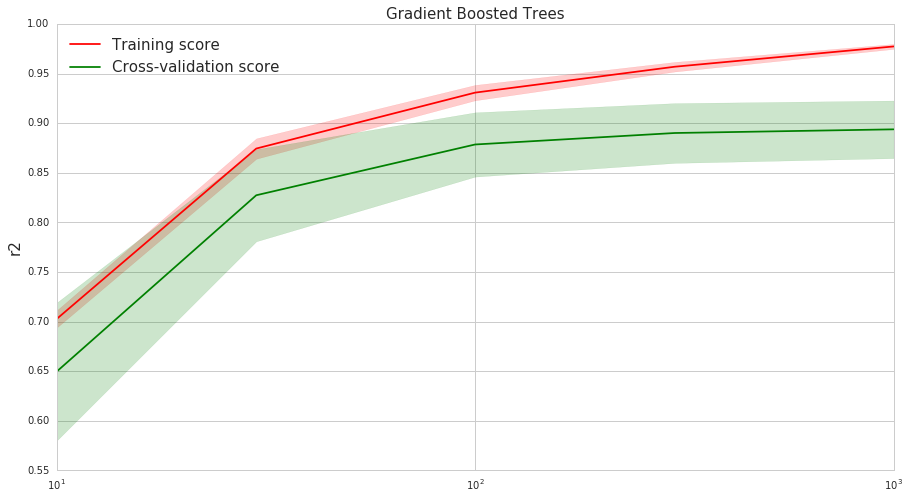

In [13]:
plot_validation_curve(estimator=GradientBoostingRegressor(), X=gX_train, y=gy_train, 
                      param_name='n_estimators', param_range=[10,30,100,300,1000], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='# of estimators', y_label='r2', 
                      n_jobs=-1)

In [ ]:
plot_validation_curve(estimator=GradientBoostingRegressor(), X=gX_train, y=gy_train, 
                      param_name='max_depth', param_range=[3,10,30,100], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='max depth', y_label='r2', 
                      n_jobs=-1)

Validation Curves Runtime: 0h:01m:48s


min_samples_split:       1    Train Score: 0.931 Test Score: 0.879
min_samples_split:       3    Train Score: 0.931 Test Score: 0.878
min_samples_split:      10    Train Score: 0.929 Test Score: 0.871
min_samples_split:      30    Train Score: 0.925 Test Score: 0.861
min_samples_split:     100    Train Score: 0.919 Test Score: 0.858


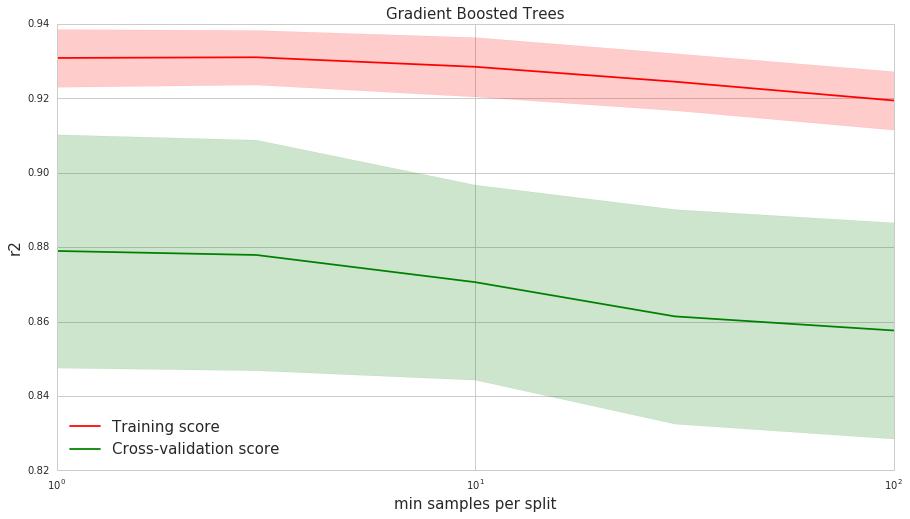

In [10]:
plot_validation_curve(estimator=GradientBoostingRegressor(), X=gX_train, y=gy_train, 
                      param_name='min_samples_split', param_range=[1,3,10,30,100], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='min samples per split', y_label='r2', 
                      n_jobs=-1)

Validation Curves Runtime: 0h:01m:41s


min_samples_leaf:       1    Train Score: 0.931 Test Score: 0.879
min_samples_leaf:       3    Train Score: 0.930 Test Score: 0.879
min_samples_leaf:      10    Train Score: 0.915 Test Score: 0.839
min_samples_leaf:      30    Train Score: 0.840 Test Score: 0.771
min_samples_leaf:     100    Train Score: 0.736 Test Score: 0.690


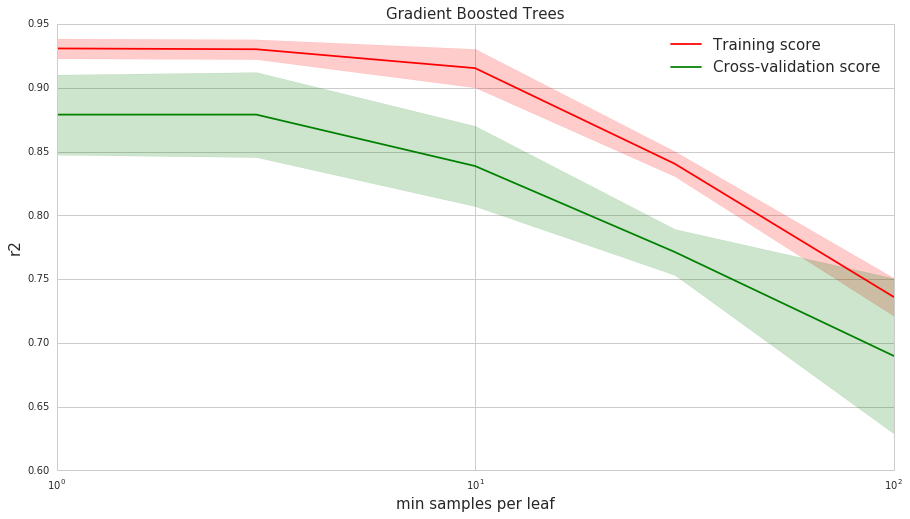

In [11]:
plot_validation_curve(estimator=GradientBoostingRegressor(), X=gX_train, y=gy_train, 
                      param_name='min_samples_leaf', param_range=[1,3,10,30,100], 
                      scoring='r2', plot_title='Gradient Boosted Trees', x_label='min samples per leaf', y_label='r2', 
                      n_jobs=-1)